# Jose Luis Padilla Valenzuela
___
<h1><center> Problema de clustering</center></h1>

___

## Segmentación de clientes de un distribuidor de venta al por mayor


### Descripción del problema:

El objetivo del problema es separar los clientes de un distribuidor al por mayor en grupos lo más homogéneos posibles pero que se diferencien entre ellos lo máximo posible de cara a realizar acciones dirigidas distintas para cada uno de los grupos. 

Haremos uso del dataset *Wholesale customers*. Este dataset se puede descargar de la siguiente ruta de la University of California Irvine (**Url:** https://archive.ics.uci.edu/ml/datasets/Wholesale+customers)

Descárgate el fichero Wholesale_customers_data.csv del campus

<img src='wholesale.jpg' width=400px ></img>

### Descripción del dataset:

El dataset cuenta con **8 variables descriptivas X**.

El número total de muestras es de 440 clientes.

**Variables independientes X:**


1. FRESH: gasto anual (u.m.) en productos frescos (Continuo);
1. MILK: gasto anual (u.m.) en productos lácteos (Continuo);
1. GROCERY: gasto anual (u.m.) en productos comestibles (Continuo);
1. FROZEN: gasto anual (u.m.) en productos congelados (Continuo)
1. DETERGENTS_PAPER: gasto anual (u.m.) en detergentes y productos de papel (Continuo)
1. DELICATESSEN: gasto anual (u.m.) en productos delicatessen (Continuo);
1. CHANNEL: Canal de clientes - Horeca (Hotel / Restaurante / Café) o Canal minorista (Nominal)
1. REGION: Región de clientes - Lisboa, Oporto u Otros (Nominal)

**Más detalles de los datos:**

Existen dos variables categóricas o nominales, "REGION" y "CHANNEL".

REGION Frequency
* Lisboa 77
* Oporto 47
* Other Region 316

CHANNEL Frequency
* Horeca 298
* Retail 142

# Carga de librerías:

In [2]:
from IPython.core.display import display, HTML
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.stats import boxcox, probplot, norm, shapiro
from sklearn.preprocessing import PowerTransformer, MinMaxScaler
from sklearn.cluster import KMeans
import os
import warnings
warnings.filterwarnings('ignore')

# Definición de funciones: 

In [3]:
def comprueba_normalidad(df, return_type='axes', title='Comprobación de normalidad'):
    '''
    '''
    fig_tot = (len(df.columns))
    fig_por_fila = 3.
    tamanio_fig = 4.
    num_filas = int( np.ceil(fig_tot/fig_por_fila) )    
    plt.figure( figsize=( fig_por_fila*tamanio_fig+5, num_filas*tamanio_fig+2 ) )
    c = 0 
    shapiro_test = {}
    lambdas = {}
    for i, col in enumerate(df.columns):
        ax = plt.subplot(num_filas, fig_por_fila, i+1)
        probplot(x = df[df.columns[i]], dist=norm, plot=ax)
        plt.title(df.columns[i])
        shapiro_test[df.columns[i]] = shapiro(df[df.columns[i]])
    plt.suptitle(title)
    plt.show()
    shapiro_test = pd.DataFrame(shapiro_test, index=['Test Statistic', 'p-value']).transpose()
    return shapiro_test

# Lectura de datos:

Con la función os.listdir() podemos obtener la lista de archivos en el directorio actual:

In [4]:
os.listdir()

['.ipynb_checkpoints',
 '1barPlot.png',
 '2.1_Titanic.ipynb',
 '3.1_Accidentes.ipynb',
 '3.2_Bolsa-checkpoint.ipynb',
 '3.2_Bolsa.ipynb',
 '4.1_Digitos-checkpoint.ipynb',
 '4.1_Digitos.ipynb',
 '4.2_Trafico-checkpoint.ipynb',
 '4.2_Trafico.ipynb',
 '4.2_Trafico2-checkpoint.ipynb',
 '5 Clasificación_redes_neuronales.ipynb',
 '5 Detector_anomalias.ipynb',
 '5 Problema de clasificación.ipynb',
 '5 Regresión_redes_neuronales.ipynb',
 '5 zProblema de clasificacion.ipynb',
 '5 zProblema de clustering.ipynb',
 '5.1_Boston_Houses.ipynb',
 'barras_simple.png',
 'BOKEH.ipynb',
 'CasoPractico01.py',
 'CasoPractico02.py',
 'CasoPractico03.py',
 'Caso_practico_Python.ipynb',
 'compas.py',
 'compas2.ipynb',
 'compascopia.py',
 'compras-checkpoint.ipynb',
 'compras.ipynb',
 'dataframe.py',
 'desktop.ini',
 'EJERCICIO_101_SOLUCION.ipynb',
 'EJERCICIO_1_SOLUCION.ipynb',
 'Estructuras_datos.ipynb',
 'finalcompas.scss',
 'FUNCIONES.ipynb',
 'GGPLOT.ipynb',
 'Herramientas_control_flujo.ipynb',
 'iris.data

In [5]:
X = pd.read_csv('C:\\Users\\jlpad\\Desktop\\BBDD\\Wholesale_customers_data.csv')
print('- El número de filas en el dataset es: {}'.format(X.shape[0]))
print('- El número de columnas en el dataset es: {}'.format(X.shape[1]))
print('- Nombres de las variables: {}'.format(list(X.columns)))
X[:5]

- El número de filas en el dataset es: 440
- El número de columnas en el dataset es: 8
- Nombres de las variables: ['Channel', 'Region', 'Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


### Primero pasamos las variables Channel y Region a valores entendibles por medio de "Mapeo":

Usando la información de la descripción podemos saber qué valor corresponde con qué descripción. 

In [6]:
X['Channel'].value_counts()

1    298
2    142
Name: Channel, dtype: int64

In [7]:
X['Region'].value_counts()

3    316
1     77
2     47
Name: Region, dtype: int64

In [8]:
# Mapeo los datos
X['Channel'] = X['Channel'].map({1:'Horeca', 2:'Retail'})
X['Region'] = X['Region'].map({3:'Other Region', 2:'Oporto', 1: 'Lisboa'})

In [9]:
X['Channel'].value_counts()

Horeca    298
Retail    142
Name: Channel, dtype: int64

In [10]:
X['Region'].value_counts()

Other Region    316
Lisboa           77
Oporto           47
Name: Region, dtype: int64

In [11]:
X.head(3)

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,Retail,Other Region,12669,9656,7561,214,2674,1338
1,Retail,Other Region,7057,9810,9568,1762,3293,1776
2,Retail,Other Region,6353,8808,7684,2405,3516,7844


# Preprocesamiento de datos

## Missings: 

Obtengo el conteo de valores faltantes por variable. En caso de haber, una de las formas de rellenarlos es:

    df['nombre_columna'] = df['nombre_columna'].fillna(valor)

In [12]:
X.isnull().sum().sum()

0

No hay ningun missing así que no hay que hacer ningún preprocesado en este paso.

# Visualizaciones y correlaciones

## Descriptivos básicos:

In [13]:
X.describe()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


Guardo en una variable **"X_cuants"** las variables numéricas, ya que voy a representarlas y aplicar alguna transformación sobre ellas.

In [14]:
X_cuants = X[['Fresh','Milk','Grocery','Frozen','Detergents_Paper','Delicassen']].copy()

## Boxplots: 

In [15]:
# Normalizamos X_cuants
X_normalizado = (X_cuants-X_cuants.mean())/X_cuants.std()
X_normalizado[:6]

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,0.052873,0.522972,-0.041068,-0.588697,-0.043519,-0.066264
1,-0.390857,0.543839,0.170125,-0.269829,0.086309,0.089050
2,-0.446521,0.408073,-0.028125,-0.137379,0.133080,2.240742
3,0.099998,-0.623310,-0.392530,0.686363,-0.498021,0.093305
4,0.839284,-0.052337,-0.079266,0.173661,-0.231654,1.297870
5,-0.204573,0.333687,-0.297299,-0.495591,-0.227879,-0.026194


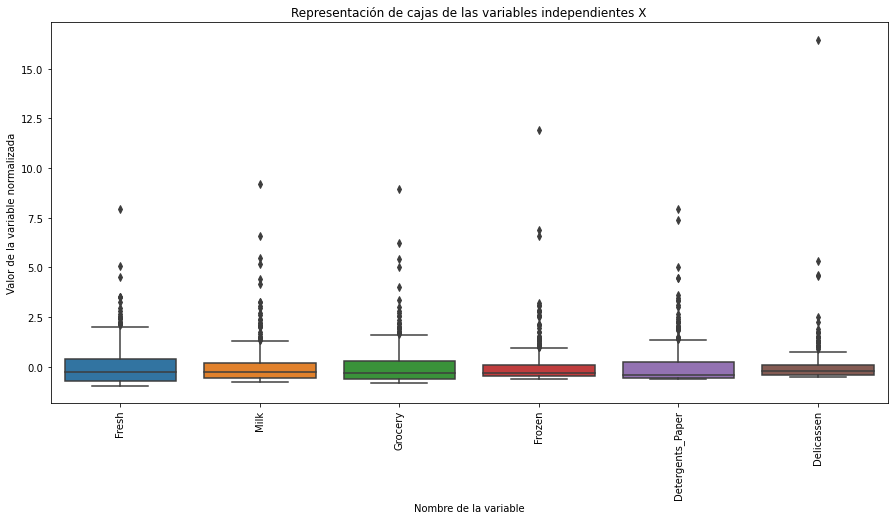

In [16]:
plt.figure(figsize=(15,7))
ax = sns.boxplot(data=X_normalizado)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title(u'Representación de cajas de las variables independientes X')
plt.ylabel('Valor de la variable normalizada')
_ = plt.xlabel('Nombre de la variable')

Por lo que vemos en las representaciones de cajas todas las variables tienen algún outlier.

## Histogramas: 

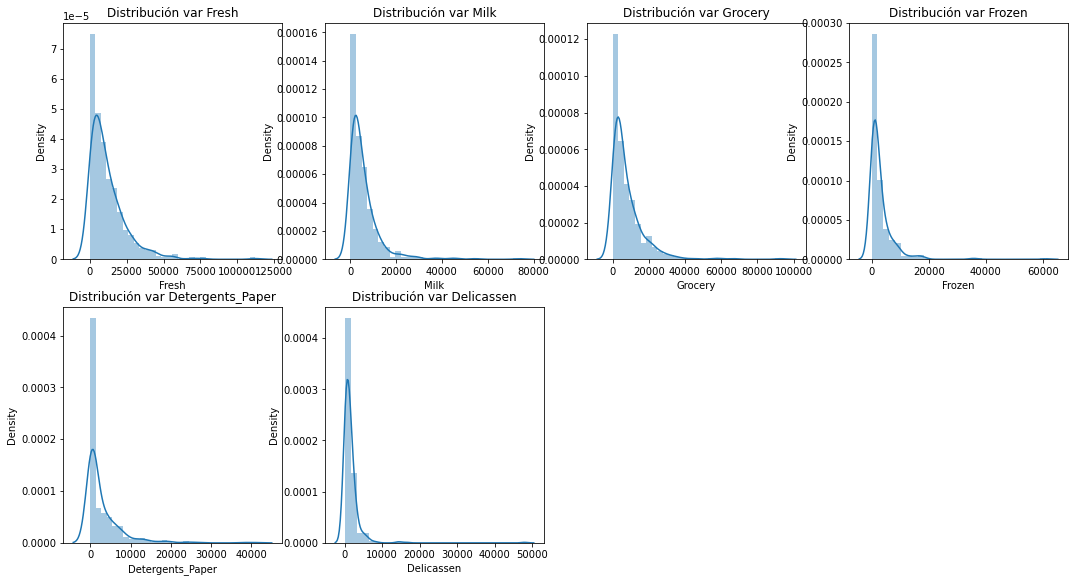

In [17]:
plt.figure(figsize=(18,20))
n = 0
for i, column in enumerate(X_cuants.columns):
    n+=1
    plt.subplot(4, 4, n)
    sns.distplot(X_cuants[column], bins=30)
    plt.title('Distribución var {}'.format(column))
plt.show()

Las variables no siguen distribuciones normales o Gaussianas, como vemos en los histogramas. 

## Matriz de correlaciones: 

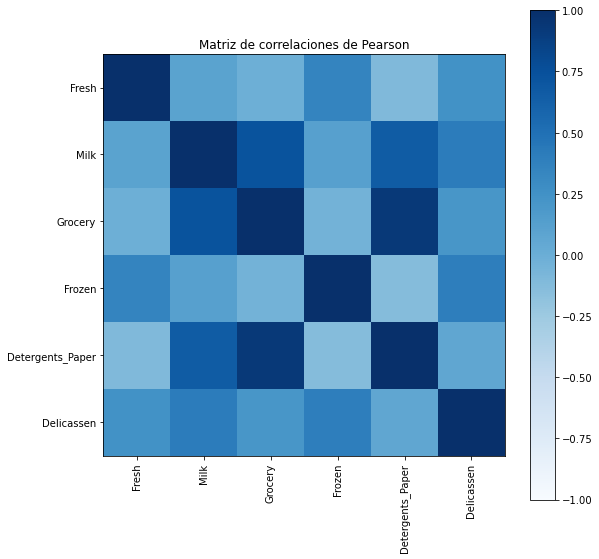

In [18]:
matriz_correlaciones = X_cuants.corr(method='pearson')
n_ticks = len(X_cuants.columns)
plt.figure( figsize=(9, 9) )
plt.xticks(range(n_ticks), X_cuants.columns, rotation='vertical')
plt.yticks(range(n_ticks), X_cuants.columns)
plt.colorbar(plt.imshow(matriz_correlaciones, interpolation='nearest', 
                            vmin=-1., vmax=1., 
                            cmap=plt.get_cmap('Blues')))
_ = plt.title('Matriz de correlaciones de Pearson')

# Transformación de datos para cumplir las hipótesis: 

Como posteriormente vamos a aplicar un algoritmo K-means, los datos deben cumplir una serie de hipótesis. 

* El K-means supone que los datos tienen una **distribución normal**. 
* Además, es muy propenso a **outliers**. 

Por lo tanto, debemos transformar las variables para que sigan una distribución normal y tratar los outliers.

## Normalización de los datos: 

La normalización de las variables es el proceso en el que se transforma una variable para que siga una distribución normal o Gaussiana. 

En general, sólo querremos normalizar los datos si vamos a usar un algoritmo de aprendizaje automático o una técnica estadística que asume que los datos están distribuidos con una forma gaussiana o normal. Por ejemplo, las pruebas t de student, ANOVAs, regresiones lineales, regresiones logísticas, análisis discriminante lineal (LDA), k-medias, etc.

Entre las formas de transformar una variable a normal se encuentran métodos como la transformación Box-Cox o el método de Yeo-Johnson. 

En las siguientes gráficas se representa el <a href='https://es.wikipedia.org/wiki/Gr%C3%A1fico_Q-Q'>Q-Q Plot</a>, que es un gráfico que compara entre dos distribuciones. En este caso, cada una de las variables con una distribución normal. Si siguen la misma distribución, los puntos caen cerca de la línea roja.

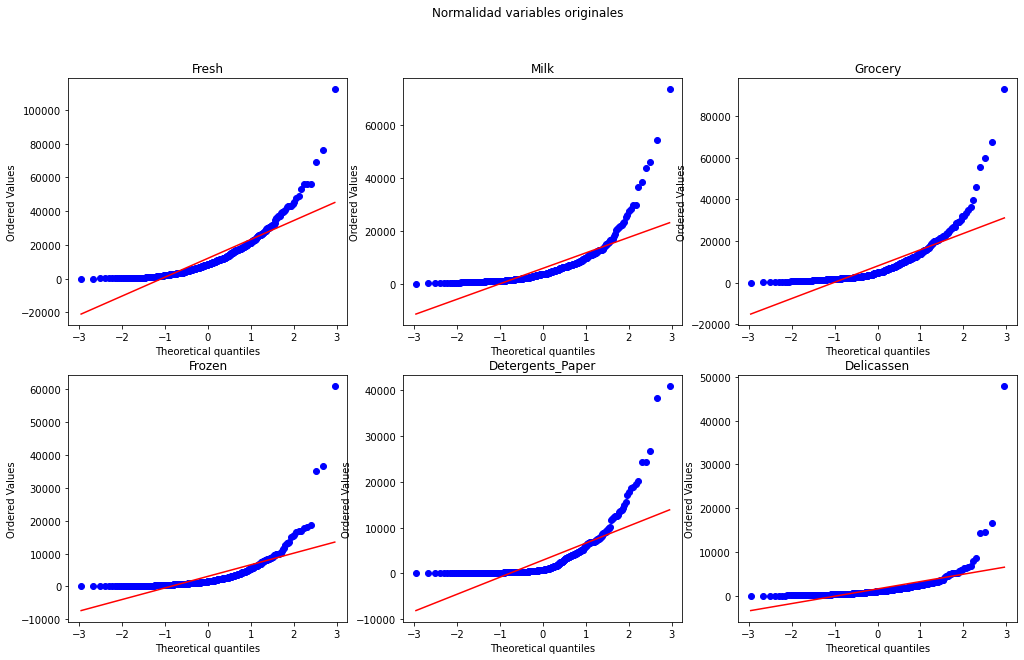

In [19]:
shapiro_test = comprueba_normalidad(X_cuants, title='Normalidad variables originales')

In [20]:
shapiro_test

,Test Statistic,p-value
Fresh,0.781436,7.918286e-24
Milk,0.628334,9.762062e-30
Grocery,0.676231,3.906209e-28
Frozen,0.528297,1.291332e-32
Detergents_Paper,0.605482,1.914593e-30
Delicassen,0.361068,1.753408e-36


Todas las variables son significativamente estadísticas no distribuidas como una normal. 

**Test de Shapiro-Wilk:** Si el p-value es menor a un nivel de significancia $\alpha$, se concluye que la distribución no proviene de una normal.

Ahora transformo las variables con una transformación Box-Cox.

In [21]:
bc = PowerTransformer(method='box-cox')
X_cuants_boxcox = bc.fit_transform(X_cuants)
X_cuants_boxcox = pd.DataFrame(X_cuants_boxcox, columns=X_cuants.columns)

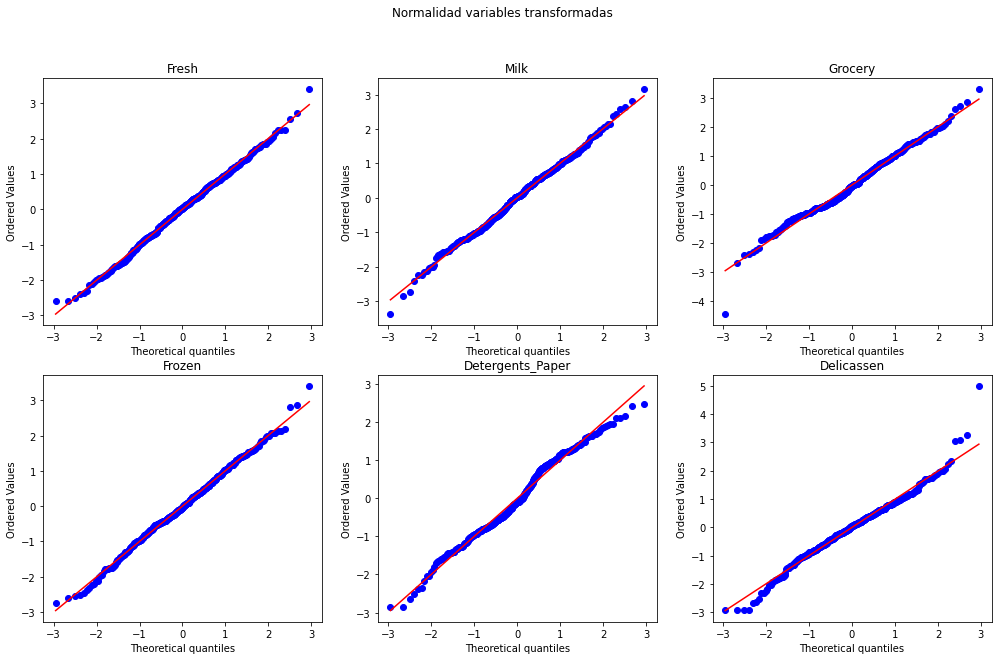

In [52]:
shapiro_test = comprueba_normalidad(X_cuants_boxcox, title='Normalidad variables transformadas')

In [53]:
shapiro_test

,Test Statistic,p-value
Fresh,0.997444,0.737640
Milk,0.996949,0.584253
Grocery,0.989162,0.002425
Frozen,0.997237,0.673468
Detergents_Paper,0.985208,0.000185
Delicassen,0.981869,0.000026


El estadístico de normalidad es muy alto en todas las variables ahora, por lo que continuamos con esta transformada. 

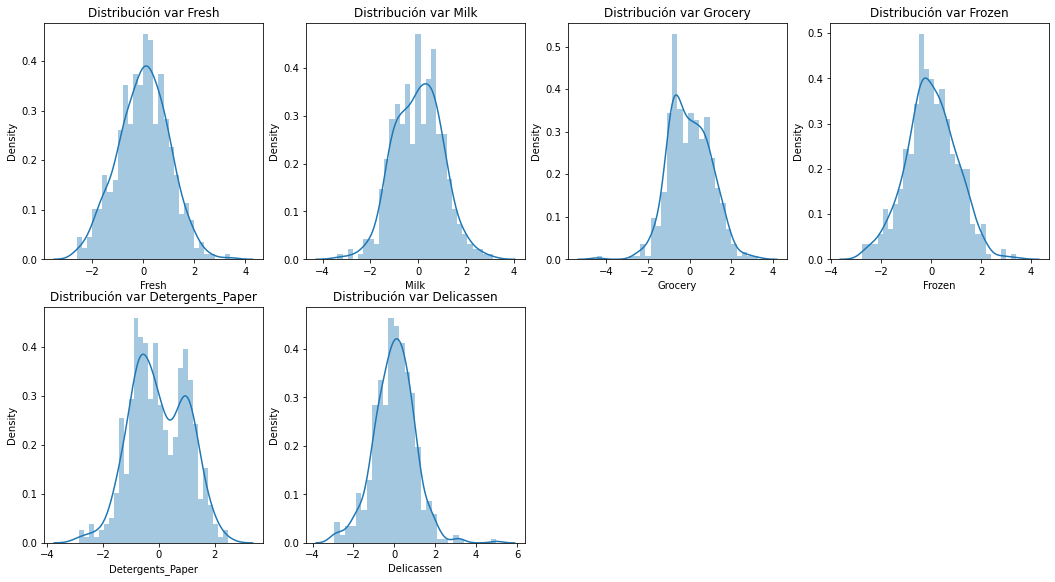

In [54]:
plt.figure(figsize=(18,20))
n = 0
for i, column in enumerate(X_cuants_boxcox.columns):
    n+=1
    plt.subplot(4, 4, n)
    sns.distplot(X_cuants_boxcox[column], bins=30)
    plt.title('Distribución var {}'.format(column))
plt.show()

Además, las distribuciones ahora sí parecen gaussianas.

## Tratamiento de outliers:

Otro de los tratamientos que debemos hacer es el de tratar los outliers o valores atípicos.

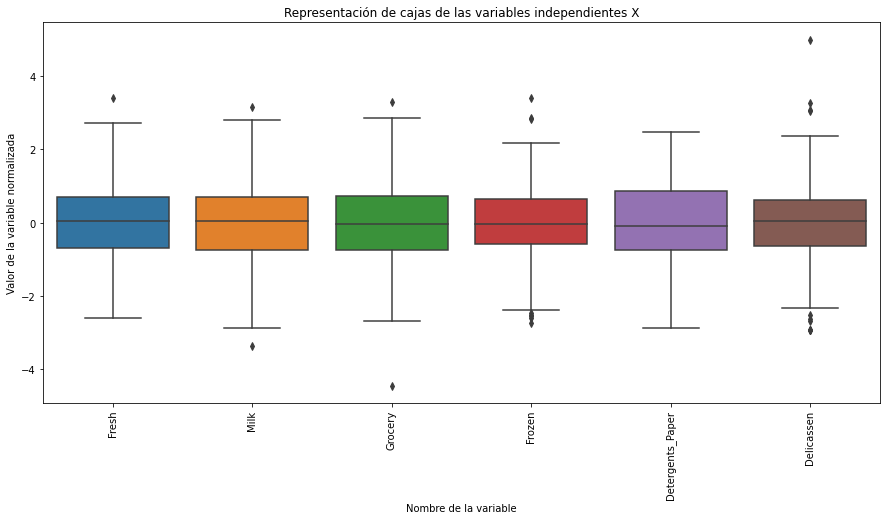

In [55]:
plt.figure(figsize=(15,7))
ax = sns.boxplot(data=X_cuants_boxcox)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title(u'Representación de cajas de las variables independientes X')
plt.ylabel('Valor de la variable normalizada')
_ = plt.xlabel('Nombre de la variable')

En este caso sustituyo los outliers por los límites inferiores (Q1-1.5IQR) y superiores (Q3+1.5IQR)
<img src='boxplot.png' width=500px></img>

In [56]:
for k in list(X_cuants_boxcox.columns):
    IQR = np.percentile(X_cuants_boxcox[k],75) - np.percentile(X_cuants_boxcox[k],25)
    
    limite_superior = np.percentile(X_cuants_boxcox[k],75) + 1.5*IQR
    limite_inferior = np.percentile(X_cuants_boxcox[k],25) - 1.5*IQR
    
    X_cuants_boxcox[k] = np.where(X_cuants_boxcox[k] > limite_superior,limite_superior,X_cuants_boxcox[k])
    X_cuants_boxcox[k] = np.where(X_cuants_boxcox[k] < limite_inferior,limite_inferior,X_cuants_boxcox[k])

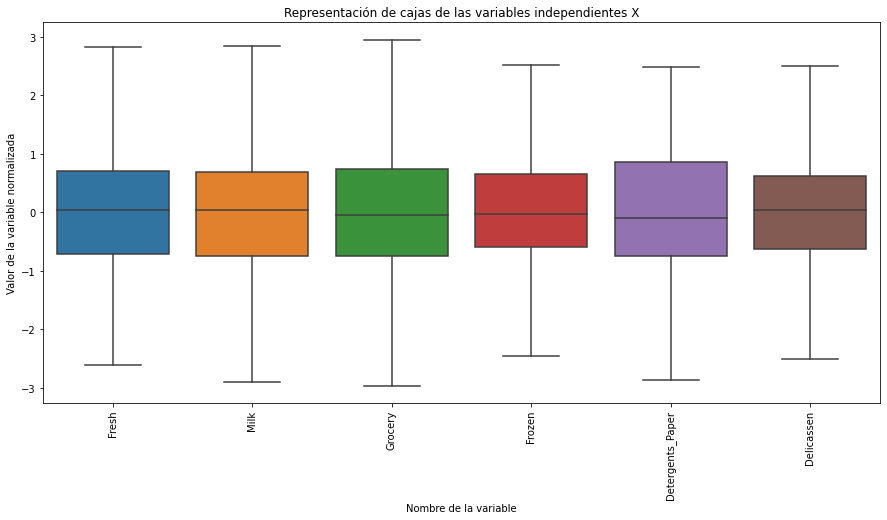

In [57]:
plt.figure(figsize=(15,7))
ax = sns.boxplot(data=X_cuants_boxcox)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title(u'Representación de cajas de las variables independientes X')
plt.ylabel('Valor de la variable normalizada')
_ = plt.xlabel('Nombre de la variable')

Ahora ya no tengo outliers y las variables están distribuidas de forma normal.

## Creo dummies de las variables categóricas

In [61]:
# En df uno las dos variables categóricas iniciales y las numéricas transformadas
df  =  pd.concat([X[['Channel','Region']],X_cuants_boxcox],axis=1)
df[:10]

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,Retail,Other Region,0.412646,0.979303,0.392937,-1.456705,0.617238,0.335779
1,Retail,Other Region,-0.111180,0.995096,0.626729,0.079718,0.748629,0.599877
2,Retail,Other Region,-0.196043,0.887891,0.408738,0.331996,0.790324,2.245295
3,Horeca,Other Region,0.457763,-0.965094,-0.156523,1.173643,-0.373844,0.606332
4,Retail,Other Region,1.028704,0.412455,0.344961,0.741520,0.364211,1.738881
5,Retail,Other Region,0.135406,0.824223,0.022040,-0.665399,0.370376,0.409937
6,Retail,Other Region,0.370219,-0.082970,0.314431,-0.901975,0.718459,-0.413296
7,Retail,Other Region,-0.052036,0.328591,0.611669,0.036460,0.754007,0.965102
8,Horeca,Other Region,-0.245943,0.039246,0.200025,-0.988133,0.342876,-0.161593
9,Retail,Other Region,-0.240330,1.118343,1.342682,-0.249063,1.278071,0.762072


In [62]:
X['Channel'].value_counts()

Horeca    298
Retail    142
Name: Channel, dtype: int64

En este paso, las categóricas las paso a dummies. Es decir, para cada valor de la variable genero una variable binaria con 1s y 0s.

In [63]:
df = pd.get_dummies(df,columns=['Channel','Region'],drop_first=True)
df[:10]

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Channel_Retail,Region_Oporto,Region_Other Region
0,0.412646,0.979303,0.392937,-1.456705,0.617238,0.335779,1,0,1
1,-0.111180,0.995096,0.626729,0.079718,0.748629,0.599877,1,0,1
2,-0.196043,0.887891,0.408738,0.331996,0.790324,2.245295,1,0,1
3,0.457763,-0.965094,-0.156523,1.173643,-0.373844,0.606332,0,0,1
4,1.028704,0.412455,0.344961,0.741520,0.364211,1.738881,1,0,1
5,0.135406,0.824223,0.022040,-0.665399,0.370376,0.409937,1,0,1
6,0.370219,-0.082970,0.314431,-0.901975,0.718459,-0.413296,1,0,1
7,-0.052036,0.328591,0.611669,0.036460,0.754007,0.965102,1,0,1
8,-0.245943,0.039246,0.200025,-0.988133,0.342876,-0.161593,0,0,1
9,-0.240330,1.118343,1.342682,-0.249063,1.278071,0.762072,1,0,1


## Escalado previo de los datos: 

Debemos escalar los datos cuando usamos métodos basados en medidas de distancias, como las SVMs, K-NNs, o K-means. En estos algoritmos, un cambio de "1" unidad en una variable numérica se le da la misma importancia independientemente de la variable. 

Por ejemplo, podemos mirar precios en distintas divisas. Un dólar es mucho más que un Yen, por lo que si hay dos productos en divisas distintas el algoritmo le dará la misma importancia a un incremento de un Yen que al de un dólar.

En este caso, como todo son gastos en productos en la misma moneda no sería necesario estrictamente. Sin embargo, al escalar estamos comparando rangos de variables. Es decir, el cliente C es de los que gasta más o de los que gasta menos en un producto. 

In [64]:
scaler = MinMaxScaler(feature_range=(0, 1))
X_escalado = scaler.fit_transform(df)
X_escalado = pd.DataFrame(X_escalado,columns=df.columns)
X_escalado.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Channel_Retail,Region_Oporto,Region_Other Region
0,0.555805,0.675704,0.566972,0.199988,0.651772,0.567532,1.0,0.0,1.0
1,0.459410,0.678453,0.606514,0.508654,0.676366,0.620280,1.0,0.0,1.0
2,0.443793,0.659790,0.569644,0.559337,0.684170,0.948915,1.0,0.0,1.0
3,0.564108,0.337200,0.474040,0.728423,0.466264,0.621569,0.0,0.0,1.0
4,0.669174,0.577020,0.558857,0.641610,0.604411,0.847771,1.0,0.0,1.0


# Segmentación utilizando un clustering K-means:

En este paso intento obtener el número de grupos óptimo utilizando la regla del codo.

In [65]:
cluster_range = range(1,20)
cluster_wss=[] 
for cluster in cluster_range:
    model = KMeans(cluster)
    model.fit(X_escalado)
    cluster_wss.append(model.inertia_)

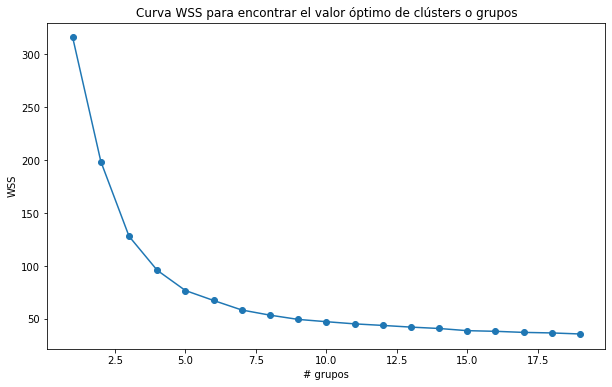

In [66]:
plt.figure(figsize=[10,6])
plt.title('Curva WSS para encontrar el valor óptimo de clústers o grupos')
plt.xlabel('# grupos')
plt.ylabel('WSS')
plt.plot(list(cluster_range),cluster_wss,marker='o')
plt.show()

En la gráfica se supone el punto óptimo cuando la curva crea un codo. En este caso sería sobre 4-6 grupos.

## Utilizo el mejor parámetro k=6: 

El número de grupos lo fijo en 6 pero lo que se suele hacer es probar varios y ver si los resultados finales tienen sentido desde el punto de vista de negocio, como luego comentaré.

#### Ajusto el modelo 

Ajusto el modelo con k=6 a los datos:

In [67]:
model = KMeans(n_clusters=6,random_state=0)
model.fit(X_escalado)

KMeans(n_clusters=6, random_state=0)

#### Predigo y obtengo clientes con su predicción 

Creo un dataframe con todas las variables y una nueva que sea la predicción del clúster asignado:

In [68]:
# Dataframe con variables originales y la predicción
df_total = X.copy()
df_total['cluster']=model.predict(X_escalado)
df_total[:2]

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,cluster
0,Retail,Other Region,12669,9656,7561,214,2674,1338,2
1,Retail,Other Region,7057,9810,9568,1762,3293,1776,2


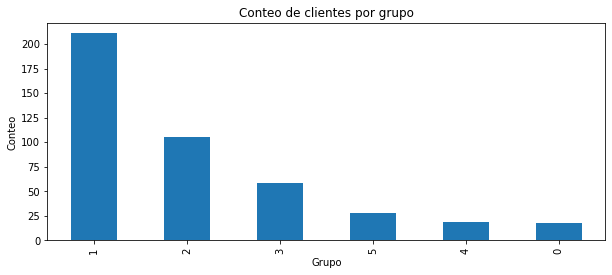

In [69]:
df_total.cluster.value_counts().plot(kind='bar', figsize=(10,4))
plt.title('Conteo de clientes por grupo')
plt.xlabel('Grupo')
_ = plt.ylabel('Conteo')

#### Obtengo características de cada grupo: 

También obtengo un dataframe con las medias de las variables en cada grupo. Esto representaría cada uno de los grupos.

Esto es muy necesario ya que las acciones que el objetivo de este problema sería hacer acciones a cada uno de los grupos por separado. Para ello es muy importante conocer cómo es cada grupo, de cara a accionar de forma distinta. 

In [70]:
# Dataframe con las medias de las variables en cada uno de los grupos
descriptivos_grupos = df_total.groupby(['cluster'],as_index=False).mean()
descriptivos_grupos

,cluster,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,0,5200.000000,10784.000000,18471.944444,2584.111111,8225.277778,1871.944444
1,1,13878.052133,3486.981043,3886.734597,3656.900474,786.682464,1518.284360
2,2,9831.504762,10981.009524,15953.809524,1513.200000,6899.238095,1826.209524
3,3,12902.254237,3870.203390,4026.135593,3127.322034,950.525424,1197.152542
4,4,7289.789474,9190.789474,16326.315789,1540.578947,8410.263158,1239.000000
5,5,11650.535714,2304.250000,4395.500000,5745.035714,482.714286,1105.892857


# Obtenemos una representación de los grupos con PCA:

Los grupos obtenidos anteriormente se pueden reducir a una dimensión menor y representarse. En este caso reduzco a dimensión=2, usando el método PCA.

In [71]:
pca2 = PCA(n_components=2)
pc = pca2.fit_transform(X_escalado)
pc_df = pd.DataFrame(pc)
pca = pd.concat([pc_df, df_total['cluster']],axis=1)
pca.columns = ['pc1','pc2','cluster']
pca[:2]

,pc1,pc2,cluster
0,0.736695,-0.260786,2
1,0.731883,-0.249084,2


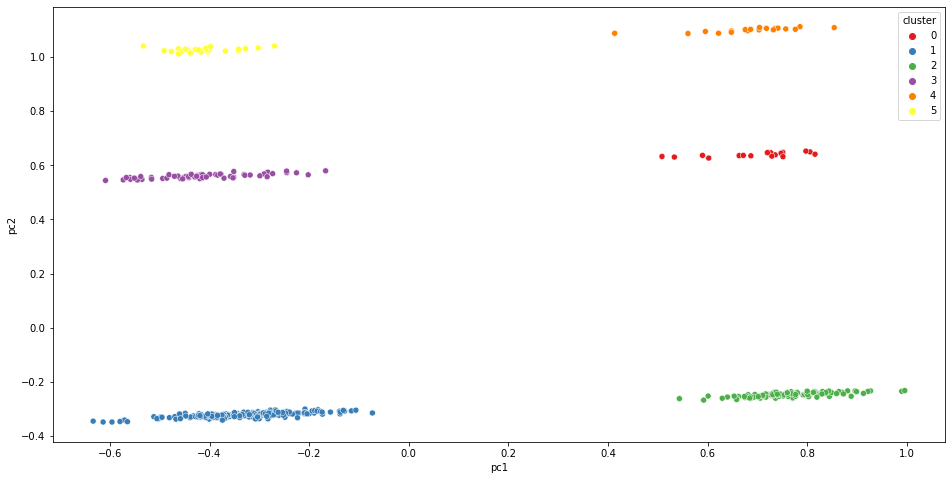

In [72]:
plt.figure(figsize=[16,8])
sns.scatterplot(x='pc1', y='pc2', hue= 'cluster', data=pca, palette='Set1')
plt.show()

Las dos componentes principales muestran que los grupos se separan de manera perfecta entre ellos. 

# Explico los grupos usando las medias de cada variable por grupo:

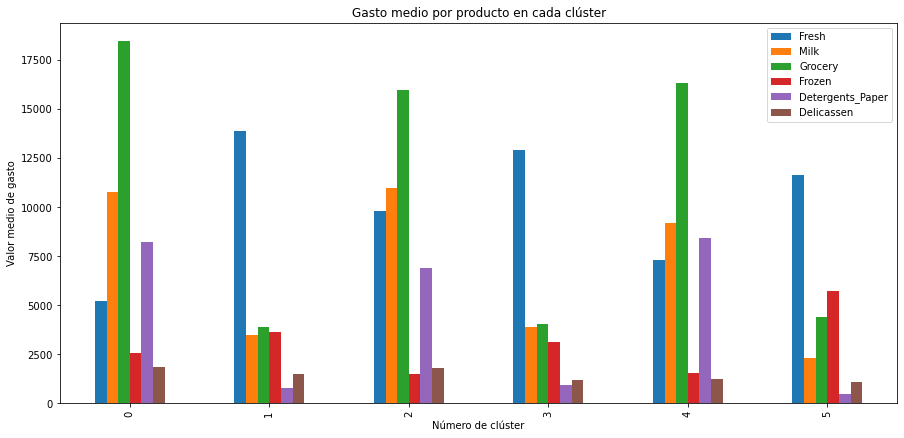

In [73]:
df_total.groupby('cluster').mean().plot(kind='bar', figsize=(15,7))
plt.title('Gasto medio por producto en cada clúster')
plt.xlabel(u'Número de clúster')
_ = plt.ylabel('Valor medio de gasto')

Por último para cada uno de los grupos obtengo su gasto medio en cada producto. 

Como anotación... también se podría analizar el comportamiento dividiendo los grupos en sus dos variables categóricas y analizando los gastos medios, de este modo se haría segmentaciones por canal, geografía y características del cliente.

In [74]:
df_total[:2]

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,cluster
0,Retail,Other Region,12669,9656,7561,214,2674,1338,2
1,Retail,Other Region,7057,9810,9568,1762,3293,1776,2
